In [37]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import fastf1, os

# one‑liner to keep plots tidy
plt.style.use('default')


cache_dir = os.path.join(os.getcwd(), '.fastf1cache')
os.makedirs(cache_dir, exist_ok=True);          
fastf1.Cache.enable_cache(cache_dir)

In [48]:
def extract_track_data(year, gp, session='Q', driver='VER',
                       speed_thresh=220, slow_thresh=120, curv_thresh=0.001):
    sess = fastf1.get_session(year, gp, session)
    sess.load()
    lap  = sess.laps.pick_drivers(driver).pick_fastest()
    tel  = lap.get_telemetry().add_distance()

  
    #--------- HEADING --------
    #Look at how X and Y change from one sample tot he next
    dx   = tel['X'].diff().fillna(0) #Delta_x
    dy   = tel['Y'].diff().fillna(0) #Delta_y

    #Turn the vector (dx, dy) into an angle in radians from the X-axis
    head = np.arctan2(dy, dx)              

    #Angles live in [-pi, pi], so if the car turns from -pi to just over +pi
    #the angle "jumps" by nearly 2pi so we need to unwrap to smooth out these turns
    head_unwrapped = pd.Series(np.unwrap(head.values), index=tel.index)

    #How much the heading changes per meter traveled
    dhead = head_unwrapped.diff().fillna(0)

    #Calculate curvature
    ds    = tel['Distance'].diff().fillna(1e-6)
    curv  = np.abs(dhead) / ds
    radius = np.where(curv > 0, 1/curv, np.inf)

    tel['curv']   = curv
    tel['radius'] = radius

      # ------ CLASSIFICATION ------
    #We now classify segments in two steps
    #Corner vs. straight by curvature
    is_corner   = tel['curv'] > curv_thresh
    #Slow vs. fast corner by speed
    is_slow     = is_corner & (tel['Speed'] <= slow_thresh)
    is_medium   = is_corner & (tel['Speed'] > slow_thresh) & (tel['Speed'] < speed_thresh)  
    is_fast     = is_corner & (tel['Speed'] >= speed_thresh)
    #Anything else is straight
    is_straight = ~is_corner

    #Assign labels
    tel['cat'] = 'straight'
    tel.loc[is_slow,    'cat'] = 'slow'
    tel.loc[is_medium,  'cat'] = 'medium'
    tel.loc[is_fast,    'cat'] = 'fast'

    #Aggregation to get a nice data dictionary
    d_dist = tel['Distance'].diff().fillna(0)
    data = {}
    for cat in ['straight','slow','medium','fast']:
        mask = tel['cat']==cat
        L   = d_dist[mask].sum()
        r   = tel.loc[mask,'radius'].replace(np.inf,np.nan).mean()
        v0  = (tel.loc[mask,'Speed']*(1000/3600)).mean()
        data[cat] = {'L': L, 'r': r, 'v0': v0}

    return data



In [39]:
tracks = {}
for name, gp in [('monaco','Monaco'), ('silverstone','British'), ('monza','Italian')]:
    tracks[name] = extract_track_data(2023, gp, 'Q', driver='VER')


core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '16', '31', '55', '44', '10', '63', '22', '4', '81', '21', '23', '18', '77', '2', '20', '27', '24', '11']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cac

In [40]:
def sim_lap_data2(track, DL, DD, DpctF, k_bal=0.5):
    geo = tracks[track]
    #Extract lengths & baseline speeds for straight/slow/medium/fast
    Ls   = geo['straight']['L'];  vs   = geo['straight']['v0']
    Lsl  = geo['slow']['L'];      vsl  = geo['slow']['v0']
    Lmed = geo['medium']['L'];    vmed = geo['medium']['v0']
    Lf   = geo['fast']['L'];      vf   = geo['fast']['v0']

    #scale speeds
    v_str = vs   * np.sqrt(1/DD)
    v_slo = vsl  * np.sqrt(DL)*(1 + k_bal*(DpctF-50)/50)
    v_med = vmed * np.sqrt(DL)   
    v_fst = vf   * np.sqrt(DL)*(1 - k_bal*(DpctF-50)/50)

    #sector times
    t_str = Ls   / v_str
    t_slo = Lsl  / v_slo
    t_med = Lmed / v_med
    t_fst = Lf   / v_fst

    #return laptime
    return t_str, t_slo, t_med, t_fst, (t_str + t_slo + t_med + t_fst)


In [41]:
#Define a set of Aero "packages" with extreme configurations
configs = {
    'Baseline'       : {'DL': 1.00,  'DD': 1.00,  'DpctF': 50},  # neutral
    'A' : {'DL': 1.4,  'DD': 1.5,  'DpctF': 20},  # + downforce and drag, rear bias
    'B'  : {'DL': 1.2,  'DD': 1.2,  'DpctF': 50},  # +downforce and drag, neutral balance
    'C'   : {'DL': 0.75,  'DD': 0.6,  'DpctF': 40},  # minimal DF, minimal drag, rear bias
    
}

#Simulate them
rows = []
for trk in tracks:
    for name, spec in configs.items():
        t = sim_lap_data2(trk, spec['DL'], spec['DD'], spec['DpctF'])[-1]
        rows.append({'Track': trk.title(), 'Config': name, 'LapTime': t})

df = pd.DataFrame(rows)

#Make a nice table to show the results
table = df.pivot(index='Track', columns='Config', values='LapTime').round(3)
print(table)

Config            A       B  Baseline       C
Track                                        
Monaco       70.535  67.400    71.742  80.506
Monza        82.279  80.683    79.573  73.884
Silverstone  79.947  83.981    86.475  86.888


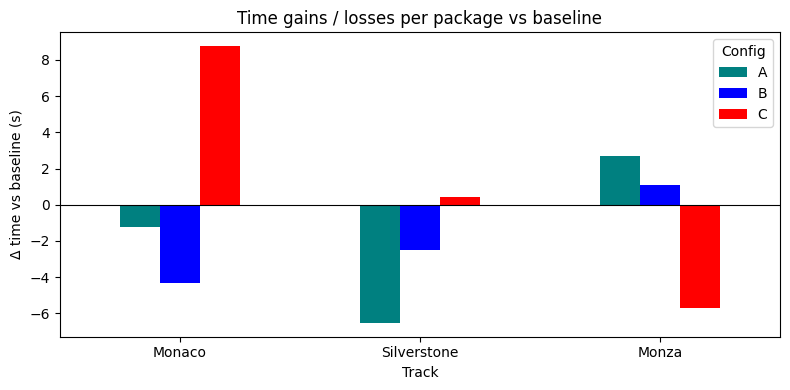

In [42]:
#Pivot results so each row is a circuit and earch column is a package
df_pivot = df.pivot(index='Track', columns='Config', values='LapTime')
df_pivot = df_pivot.loc[['Monaco','Silverstone','Monza']]

#Isolate each package's net effect by subtracting baseline
delta = df_pivot.subtract(df_pivot['Baseline'], axis=0).drop(columns='Baseline')

df_plot = delta.rename(columns={
    'A': 'A',
    'B': 'B',
    'C': 'C'
})

#Define fixed colors for each package
colors = {
    'A': 'teal',   # blue
    'B': 'blue',   # orange
    'C': 'red',    # green
    'Baseline': 'grey'
}
#Plot gains/losses relative to the baseline
ax = delta.plot(
    kind='bar',
    figsize=(8, 4),
    color=[colors[name] for name in df_plot.columns]
)
plt.axhline(0, color='k', linewidth=0.8)
plt.ylabel('Δ time vs baseline (s)')
plt.title('Time gains / losses per package vs baseline')
plt.xticks(rotation=0)
plt.legend(title='Config', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


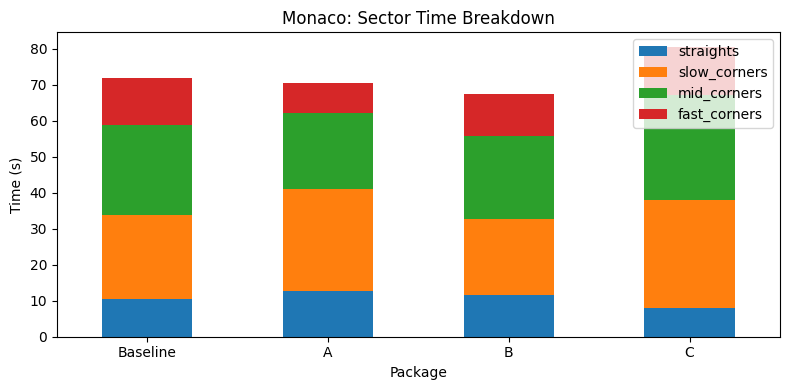

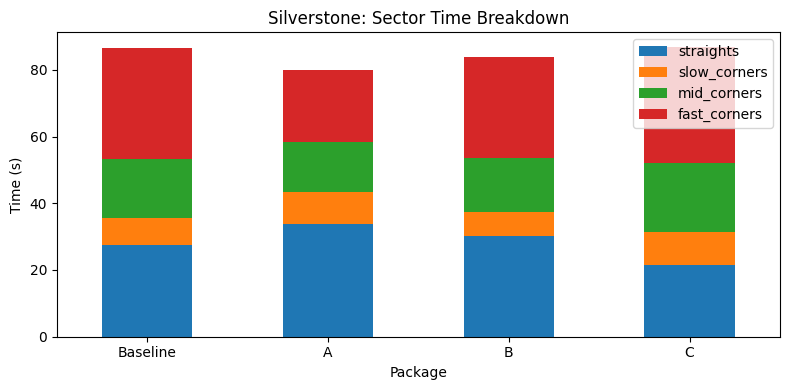

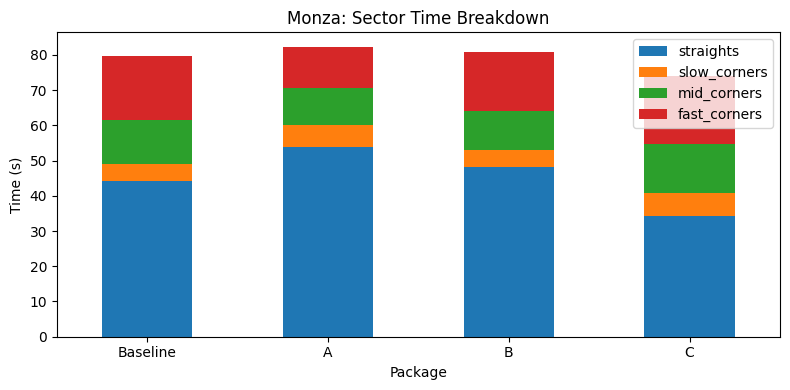

In [43]:
#Now we want to break up the laptimes into sectors to help
#us see why each track favours a different setup. 

rows = []
for trk in tracks:
    for cfg, spec in configs.items():
        t_str, t_slo, t_med, t_fst, tot = sim_lap_data2(trk,
                                                     spec['DL'],
                                                     spec['DD'],
                                                     spec['DpctF'])
        rows.append({
            'Track':      trk.title(),
            'Package':     cfg,
            'straights': t_str,
            'slow_corners': t_slo,
            'mid_corners' : t_med,
            'fast_corners': t_fst,
            'LapTime':  tot
        })
df_sec = pd.DataFrame(rows)


for trk in df_sec['Track'].unique():
    dfp = df_sec[df_sec['Track']==trk].set_index('Package')[['straights','slow_corners','mid_corners', 'fast_corners']]
    ax = dfp.plot(kind='bar', stacked=True, figsize=(8,4))
    ax.set_ylabel('Time (s)')
    ax.set_title(f'{trk}: Sector Time Breakdown')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



C:\Users\Emmeline Kjellgren\AppData\Local\Temp\ipykernel_34296\2484916746.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = plt.cm.get_cmap('tab10', len(cfg_names))
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for wea

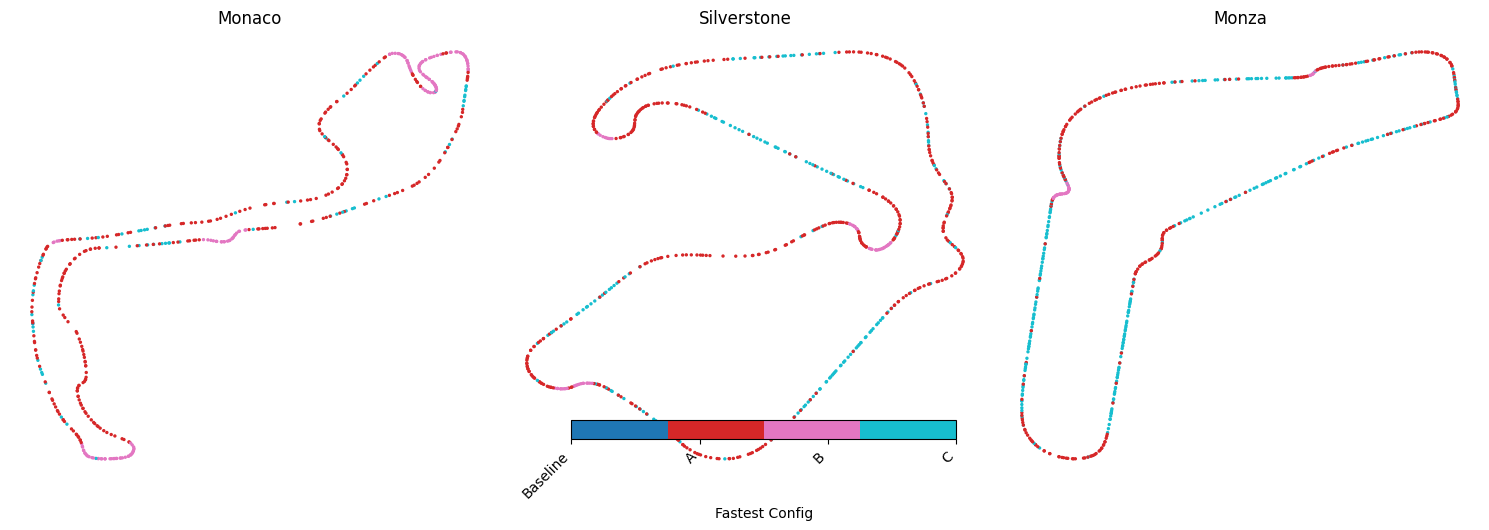

In [44]:
#Setup dominance
def classify_telemetry(tel, curv_thresh=0.001, slow_thresh=120, speed_thresh=220):
    dx = tel['X'].diff().fillna(0)
    dy = tel['Y'].diff().fillna(0)
    head = np.arctan2(dy, dx)
    head_unwrapped = pd.Series(np.unwrap(head.values), index=tel.index)
    dhead = head_unwrapped.diff().fillna(0)
    ds = tel['Distance'].diff().fillna(1e-6)
    tel['curv'] = np.abs(dhead) / ds

    is_corner = tel['curv'] > curv_thresh
    is_slow   = is_corner & (tel['Speed'] <= slow_thresh)
    is_med    = is_corner & (tel['Speed'] >  slow_thresh) & (tel['Speed'] < speed_thresh)
    is_fast   = is_corner & (tel['Speed'] >= speed_thresh)

    tel['cat'] = 'straight'
    tel.loc[is_slow,  'cat'] = 'slow'
    tel.loc[is_med,   'cat'] = 'medium'
    tel.loc[is_fast,  'cat'] = 'fast'
    return tel

cfg_names    = list(configs.keys())
config_code  = {name:i for i,name in enumerate(cfg_names)}
cmap         = plt.cm.get_cmap('tab10', len(cfg_names))

def plot_config_dominance_all(gp_list):
    fig, axes = plt.subplots(1, len(gp_list), figsize=(5*len(gp_list), 5))
    for ax, (trk_key, gp_name) in zip(axes, gp_list):
        sess = fastf1.get_session(2023, gp_name, 'Q'); sess.load()
        lap  = sess.laps.pick_fastest()
        tel  = lap.get_telemetry().add_distance()
        tel  = classify_telemetry(tel)

        ds = tel['Distance'].diff().fillna(0)
        #compute per‐point times for each package
        tbl = {}
        for name in cfg_names:
            DL, DD, DpctF = configs[name].values()
            v_s   = tracks[trk_key]['straight']['v0'] * np.sqrt(1/DD)
            v_sl  = tracks[trk_key]['slow']['v0']     * np.sqrt(DL)*(1+0.5*(DpctF-50)/50)
            v_med = tracks[trk_key]['medium']['v0']   * np.sqrt(DL)
            v_f   = tracks[trk_key]['fast']['v0']     * np.sqrt(DL)*(1-0.5*(DpctF-50)/50)
            v_inst = np.select(
                [tel['cat']=='straight', tel['cat']=='slow', tel['cat']=='medium', tel['cat']=='fast'],
                [v_s, v_sl, v_med, v_f]
            )
            tbl[name] = ds / v_inst

        df_times = pd.DataFrame(tbl)
        winner   = df_times.idxmin(axis=1).map(config_code)

        sc = ax.scatter(
            tel['X'], tel['Y'], c=winner,
            cmap=cmap, vmin=0, vmax=len(cfg_names)-1, s=2
        )
        ax.set_title(trk_key.title())
        ax.axis('off')

    cbar = fig.colorbar(sc, ax=axes.ravel(),
                        ticks=range(len(cfg_names)),
                        orientation='horizontal', fraction=0.05, pad=0.05)
    cbar.ax.set_xticklabels(cfg_names, rotation=45, ha='right')
    cbar.set_label('Fastest Config')
    plt.tight_layout()
    plt.show()

plot_config_dominance_all([
    ('monaco',      'Monaco'),
    ('silverstone', 'British'),
    ('monza',       'Italian')
])



core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '16', '31', '55', '44', '10', '63', '22', '4', '81', '21', '23', '18', '77', '2', '20', '27', '24', '11']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cac

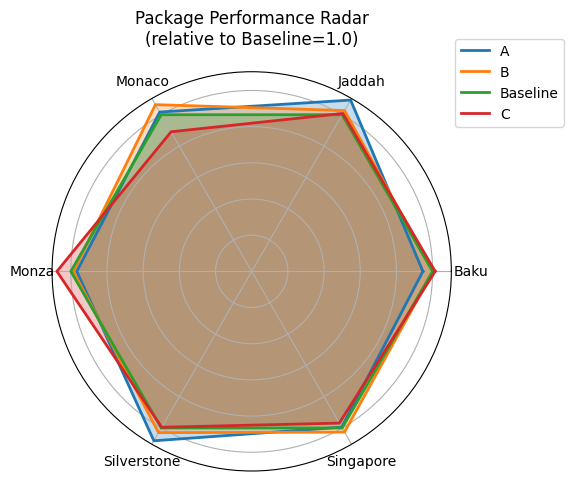

In [85]:
#We can compare some more circuits
track_list = [
    ('monaco',      'Monaco'),
    ('silverstone', 'Silverstone'),
    ('monza',       'Monza'),
    ('jeddah',         'Jaddah'),
    ('singapore',      'Singapore'),
    ('baku', 'Baku'),
]
#Extract geometry for all five circuits
tracks = {
    key: extract_track_data(2023, gp, 'Q', driver='VER')
    for key, gp in track_list
}

rows = []
for cfg, spec in configs.items():
    for key, name in track_list:
        res = sim_lap_data2(key, spec['DL'], spec['DD'], spec['DpctF'])
        # if sim_lap_data2 returns a tuple, the total is the last element
        lap = res[-1] if isinstance(res, tuple) else res
        rows.append({'Config': cfg, 'Track': name, 'LapTime': lap})
df_perf = pd.DataFrame(rows)


perf = df_perf.pivot(index='Config', columns='Track', values='LapTime')

#Normalize versus baseline
baseline = perf.loc['Baseline']
score    = baseline / perf

#Make a Radar chart
tracks_names = perf.columns.tolist()
angles = np.linspace(0, 2*np.pi, len(tracks_names), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'polar': True})
for cfg in score.index:
    vals = score.loc[cfg].tolist()
    vals += vals[:1]
    ax.plot(angles, vals, label=cfg, linewidth=2)
    ax.fill(angles, vals, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(tracks_names)
ax.set_yticklabels([])                  
ax.set_title("Package Performance Radar\n(relative to Baseline=1.0)", pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))

plt.tight_layout()
plt.show()



In [81]:
config_colors = {
    'Baseline'           : 'gray',
    'A' : 'teal',
    'B'         : 'blue',
    'C'     : 'red'
}


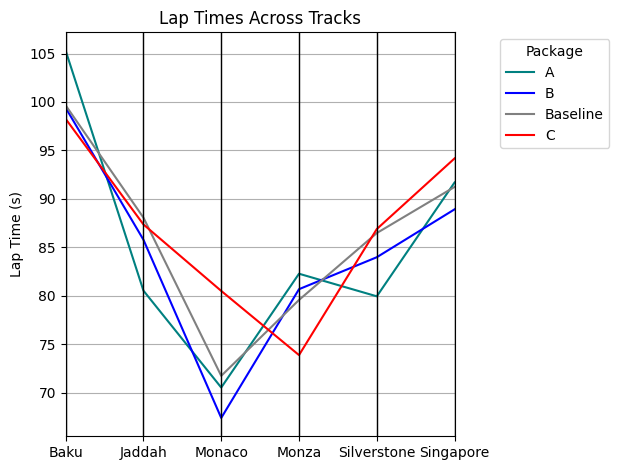

In [87]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

# Pivot fresh from df_perf
perf_pc = df_perf.pivot(
    index='Config',
    columns='Track',
    values='LapTime'
).reset_index()

# Draw parallel‐coordinates
parallel_coordinates(
    perf_pc,
    class_column='Config',
    cols=[c for c in perf_pc.columns if c != 'Config'],
    color=[config_colors[c] for c in perf_pc['Config']]
)

plt.title('Lap Times Across Tracks')
plt.ylabel('Lap Time (s)')
plt.legend(title='Package', bbox_to_anchor=(1.1, 1.0))
plt.tight_layout()
plt.show()
